In [1]:
%matplotlib inline

In [2]:
import pyathena as pa

In [3]:
import pyathena as pa
import pandas as pd
import xarray as xr
import glob
import os

In [4]:
import matplotlib.pyplot as plt

Reading a history file:/tigress/changgoo//R8_8pc_metal/hst/R8_8pc_metal.hst.p
Reading a history file:/tigress/changgoo//RPS_8pc_ICM1/hst/RPS_8pc_ICM1.hst.p
52582.0139604 K / cm3 47936.0431923 K / cm3 34567.4920511 K / cm3 183.708541923 3.2576035238 solMass / pc2
Reading a history file:/tigress/changgoo//RPS_8pc_ICM2/hst/RPS_8pc_ICM2.hst.p
52582.0139604 K / cm3 47936.0431923 K / cm3 69134.9841023 K / cm3 1120.20799848 6.51520704759 solMass / pc2
Reading a history file:/tigress/changgoo//RPS_8pc_noICM_newacc/hst/RPS_8pc_noICM_newacc.hst.p
52582.0160923 K / cm3 47936.0451358 K / cm3 0.0 K / cm3 0.0 0.0 solMass / pc2
Reading a history file:/tigress/changgoo//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
52582.0160923 K / cm3 47936.0451358 K / cm3 34567.4920511 K / cm3 183.70853083 3.2576035238 solMass / pc2


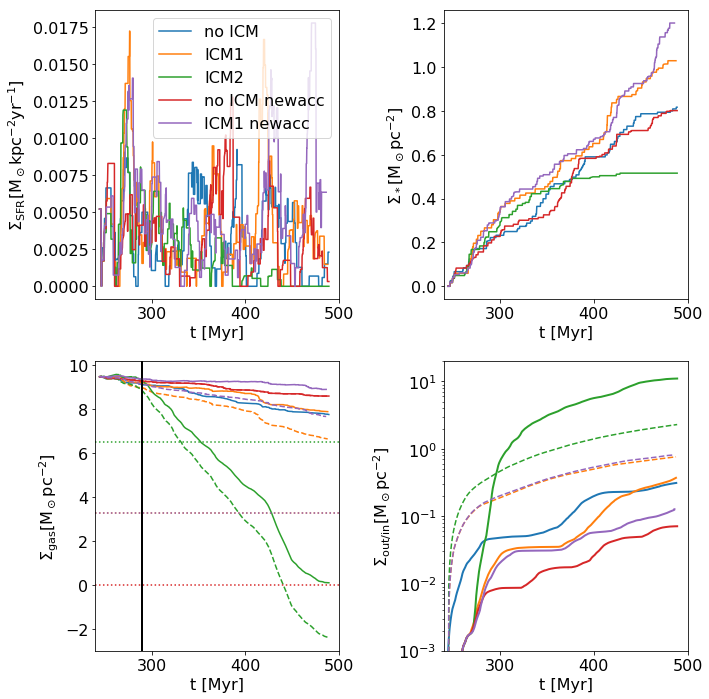

In [7]:
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['font.size']=16
import os,glob
labels=['no ICM','ICM1','ICM2','no ICM newacc','ICM1 newacc']
ids=['R8_8pc_metal','RPS_8pc_ICM1','RPS_8pc_ICM2','RPS_8pc_noICM_newacc','RPS_8pc_ICM1_newacc']
base='/tigress/changgoo/'
for j,problem_id in enumerate(ids):
    rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    Myr=unit['time'].to('Myr').value
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    par=pa.get_params(parfile)
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']

    surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_ys=(hst.msp-hst.msp.iloc[0])*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_gas=np.interp(250,hst.time,surf)*u.M_sun/c.pc**2
    surf_star=par['SurfS']*u.M_sun/c.pc**2
    surf_dm=par['rhodm']*Lz*u.M_sun/c.pc**2
#    W1=2*np.pi*c.G*surf_gas*surf_star
#    W2=2*np.pi*c.G*surf_gas*surf_star
#    print (W1/c.k_B).cgs,(W2/c.k_B).cgs
    if par.has_key('d_icm'):
        z=np.arange(0,Lz/2.)
        gstar=2*np.pi*c.G*surf_star*z/np.sqrt(z**2+par['zstar']**2)
        gdm=4*np.pi*c.G*par['rhodm']*z/(1+(z/par['R0'])**2)*u.M_sun/c.pc**2
        W_star=(surf_gas*gstar/c.k_B).cgs
        W_dm=(surf_gas*gdm/c.k_B).cgs
        W=W_star+W_dm
        Pram=par['d_icm']*par['v_icm']**2*(unit['density']*unit['velocity']**2/c.k_B).cgs
        z0=np.interp(Pram.value,W.value,z)
        surf_crit=(Pram/(gstar+gdm)[-1]*c.k_B).to('M_sun/pc^2')
        print W_star[-1],W_dm[-1],Pram,z0,surf_crit
    plt.subplot(221)
    l,=plt.plot(hst.sfr10,label=labels[j])

    plt.subplot(222)
    hst_later=hst.loc[250:500,:]
    sf=hst_later.sfr10.cumsum()*0.1*Myr
    l,=plt.plot(surf_ys,label=labels[j])
#plt.plot(surf_ys,color=l.get_color())
    plt.subplot(223)
    l,=plt.plot(surf)
    if par.has_key('d_icm'):        
        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
        plt.plot(hst.time*Myr,surf.values.value-inflow_anal.values,color=l.get_color(),ls='--')
        plt.axhline(surf_crit.value,ls=':',color=l.get_color())
    

    plt.axvline(290,color='k')
    plt.subplot(224)
    plist=['phase1','phase2','phase3','phase4','phase5']
    datasets = xr.Dataset()
    for phase in plist:
        path='{}{}/zprof_merged/{}.{}.zprof.nc'.format(base,problem_id,problem_id,phase)
        with xr.open_dataarray(path) as da: da.load()
        datasets[phase]=da
    zprof_ds=datasets
    zpw=zprof_ds.to_array().sum(dim='variable')
    
    zpw=zpw.sel(taxis=slice(250,500))
    Munit=(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
    outflow=((zpw.loc['M3']/zpw.loc['A'])[-1,:].data).cumsum()*Munit*Myr
    inflow=((zpw.loc['M3']/zpw.loc['A'])[0,:]).data.cumsum()*Munit*Myr
    out=(hst_later.mass.iloc[0]-hst_later.mass-(hst_later.msp-hst_later.msp.iloc[0]))*Lz*(unit['density']*unit['length']).to('Msun/pc^2').value

    if problem_id.startswith('RPS'):
        l,=plt.plot(zpw.taxis*Myr,outflow,label=labels[j],lw=2)
        plt.plot(zpw.taxis*Myr,inflow,color=l.get_color(),ls='--')
        inflow_anal=(zpw.taxis-zpw.taxis[0])*Myr*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
        #plt.plot(zpw.taxis*Myr,inflow_anal,color=l.get_color(),ls='--')
    else:
        outflow=outflow-inflow
        l,=plt.plot(zpw.taxis*Myr,outflow,label=labels[j],lw=2)

    plt.yscale('log')
    plt.ylim(1.e-3,20)
axes=plt.gcf().axes
plt.setp(axes,'xlim',(240,500))
plt.setp(axes,'xlabel','t [Myr]')
plt.setp(axes[0],'ylabel',r'$\Sigma_{\rm SFR} [{\rm M_\odot kpc^{-2} yr^{-1}}]$')
plt.setp(axes[1],'ylabel',r'$\Sigma_{\rm *} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[2],'ylabel',r'$\Sigma_{\rm gas} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[3],'ylabel',r'$\Sigma_{\rm out/in} [{\rm M_\odot pc^{-2}}]$')
axes[0].legend()
plt.tight_layout()

In [8]:
MFunit=(unit['density']*unit['velocity']).to('Msun/pc^2/Myr').value
Munit=(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value

In [9]:
z=np.arange(0,Lz/2.)

Reading a history file:/tigress/changgoo//RPS_8pc_ICM1/hst/RPS_8pc_ICM1.hst.p
3.2576035238 solMass / pc2 34567.4920511 K / cm3
Reading a history file:/tigress/changgoo//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
3.2576035238 solMass / pc2 34567.4920511 K / cm3


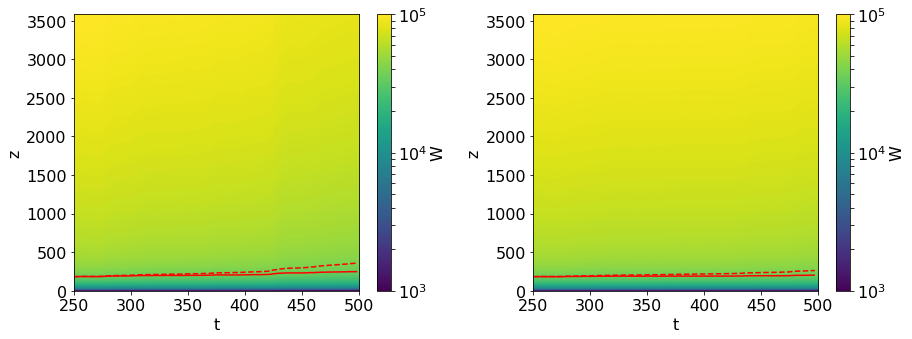

In [13]:
ids=['RPS_8pc_ICM1','RPS_8pc_ICM1_newacc']
i=1
plt.figure(figsize=(13,5))
plt.rcParams['font.size']=16
for problem_id in ids:
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    par=pa.get_params(parfile)
    if par.has_key('d_icm'):
        Pram=par['d_icm']*par['v_icm']**2*(unit['density']*unit['velocity']**2/c.k_B).cgs
        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2')
        Lz=par['x3max']-par['x3min']
        surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
        gstar=2*np.pi*c.G*par['SurfS']*u.M_sun/c.pc**2*z/np.sqrt(z**2+par['zstar']**2)
        gdm=4*np.pi*c.G*par['rhodm']*z/(1+(z/par['R0'])**2)*u.M_sun/c.pc**2
        W2d=np.array((surf[np.newaxis,:]*(gstar+gdm)[:,np.newaxis]/c.k_B).cgs)
        dsurf=surf-inflow_anal
        W2d_gas=np.array((dsurf[np.newaxis,:]*(gstar+gdm)[:,np.newaxis]/c.k_B).cgs)
        plt.subplot(1,2,i)
        im=plt.imshow(W2d,origin='lower',extent=[250,500,0,Lz/2],aspect='auto',norm=LogNorm(vmin=1.e3,vmax=1.e5))
        cs=plt.contour(hst.time,z,W2d,[Pram.value],colors='r')
        cs=plt.contour(hst.time,z,W2d_gas,[Pram.value],colors='r',linestyles='--')
        #plt.clabel(cs, fontsize=9, inline=1)
        surf_crit=(Pram/(gstar+gdm)[-1]*c.k_B).to('M_sun/pc^2')
        print surf_crit,Pram
        i=i+1
        plt.xlabel('t')
        plt.ylabel('z')
        plt.colorbar(im,label='W')
plt.tight_layout()

0.0
R8_8pc_metal 0.60821533203125 0.3184814453125
0.0
RPS_8pc_ICM1 0.6116943359375 0.3525390625
0.0
RPS_8pc_ICM2 0.61785888671875 0.4190673828125


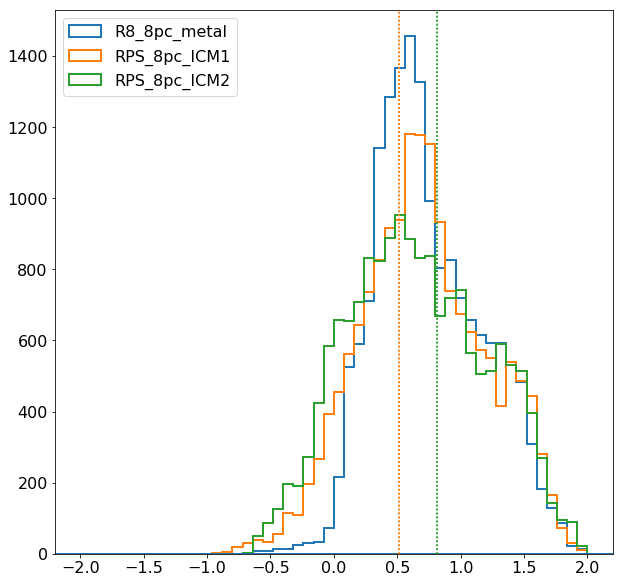

In [9]:
import pandas as pd
for i in range(270,271):
    surfnames=[]
    for problem_id in ids:
        surfname='%s/%s/surf/%s.%04d.surf.p' % (base,problem_id,problem_id,i)
        scalname='%s/%s/surf/%s.%04d.scal0.p' % (base,problem_id,problem_id,i)
        surf=pd.read_pickle(surfname)
        data=surf['z']['data']
        plt.hist(np.log10(data.flat),range=[-2,2],bins=50,label=problem_id,histtype='step',lw=2)
        if os.path.isfile(scalname): 
            scal=pd.read_pickle(scalname)
            data2=scal['z']['data']
            icm_area=(data2>0.1).sum()
            icm_frac=icm_area/128./128.
            print icm_frac
            plt.axhline(icm_frac)
        plt.axvline(np.log10(surf_crit.value),linestyle=':',color='C2')
        plt.axvline(np.log10(surf_crit.value/2),linestyle=':',color='C1')
#        plt.axvline(np.log10(surf_crit.value/4))
        print problem_id,(data<surf_crit.value).sum()/128./128.,(data<surf_crit.value/2).sum()/128./128.
plt.legend()